In [1]:
import cv2
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import time

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# --- 1. CONFIGURATION ---
DATA_BASE_DIR = '/content/drive/MyDrive/data'
CLAHE_BASE_DIR = '/content/drive/MyDrive/clahe_enhanced_brains'
PREPROCESSED_BASE_DIR = '/content/drive/MyDrive/processed_images'
SKULL_MASK_BASE_DIR = '/content/drive/MyDrive/skull_stripped_masks'
TUMOR_TYPES = ['Meningioma', 'Glioma', 'Pituitary tumor']
PRED_MASK_BASE_DIR = '/content/drive/MyDrive/kmeans_tumor_masks'
K_CLUSTERS = 3 # Number of clusters (e.g., Brain, Tumor, Ventricles)

In [4]:
def segment_tumor_otsu(clahe_img):
    """
    Applies Otsu's thresholding. We keep this to show why it fails.

    """
    ret, otsu_mask = cv2.threshold(clahe_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return otsu_mask

# --- ALGORITHM 2: ROBUST K-MEANS (The "Successful" Method) ---
def segment_tumor_kmeans_robust(clahe_img, k_clusters=3):
    """
    Segments the tumor from a CLAHE-enhanced brain image using K-Means.
    This version intelligently selects the tumor by finding the
    smallest, non-background cluster.

    """
    # 1. Reshape image and convert to float32
    Z = clahe_img.reshape((-1, 1))
    Z = np.float32(Z)

    # 2. Cluster the *entire* image (including background)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    ret, label, center = cv2.kmeans(Z, k_clusters, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

    # 3. Get cluster properties (area and brightness)
    cluster_areas = []
    for i in range(k_clusters):
        cluster_areas.append(np.sum(label == i))
    cluster_centers = center.flatten()

    # 4. Find background label (cluster center closest to 0)
    bg_label = np.argmin(cluster_centers)

    # 5. Find tumor label (smallest non-background cluster)
    tumor_label = -1
    smallest_area = float('inf')

    for i in range(k_clusters):
        if i == bg_label:
            continue # Skip the background

        # This logic assumes the tumor is the smallest non-background region
        if cluster_areas[i] < smallest_area:
            smallest_area = cluster_areas[i]
            tumor_label = i

    if tumor_label == -1: # Fallback in case K=2 or other issue
         return np.zeros_like(clahe_img) # Return empty mask

    # 6. Create final mask
    mask = (label == tumor_label).reshape(clahe_img.shape).astype(np.uint8) * 255
    return mask

In [5]:
TUMOR_TYPE_EXAMPLE = 'Glioma'
EXAMPLE_FILE = '1841.png'

# Load the single enhanced image
clahe_img_path = os.path.join(CLAHE_BASE_DIR, TUMOR_TYPE_EXAMPLE, EXAMPLE_FILE.replace('.png', '_clahe.png'))
clahe_img = cv2.imread(clahe_img_path, 0)

# Load the Ground Truth for comparison
gt_mask_path = os.path.join(DATA_BASE_DIR, TUMOR_TYPE_EXAMPLE, EXAMPLE_FILE.replace('.png', '_mask.png'))
gt_mask = cv2.imread(gt_mask_path, 0)

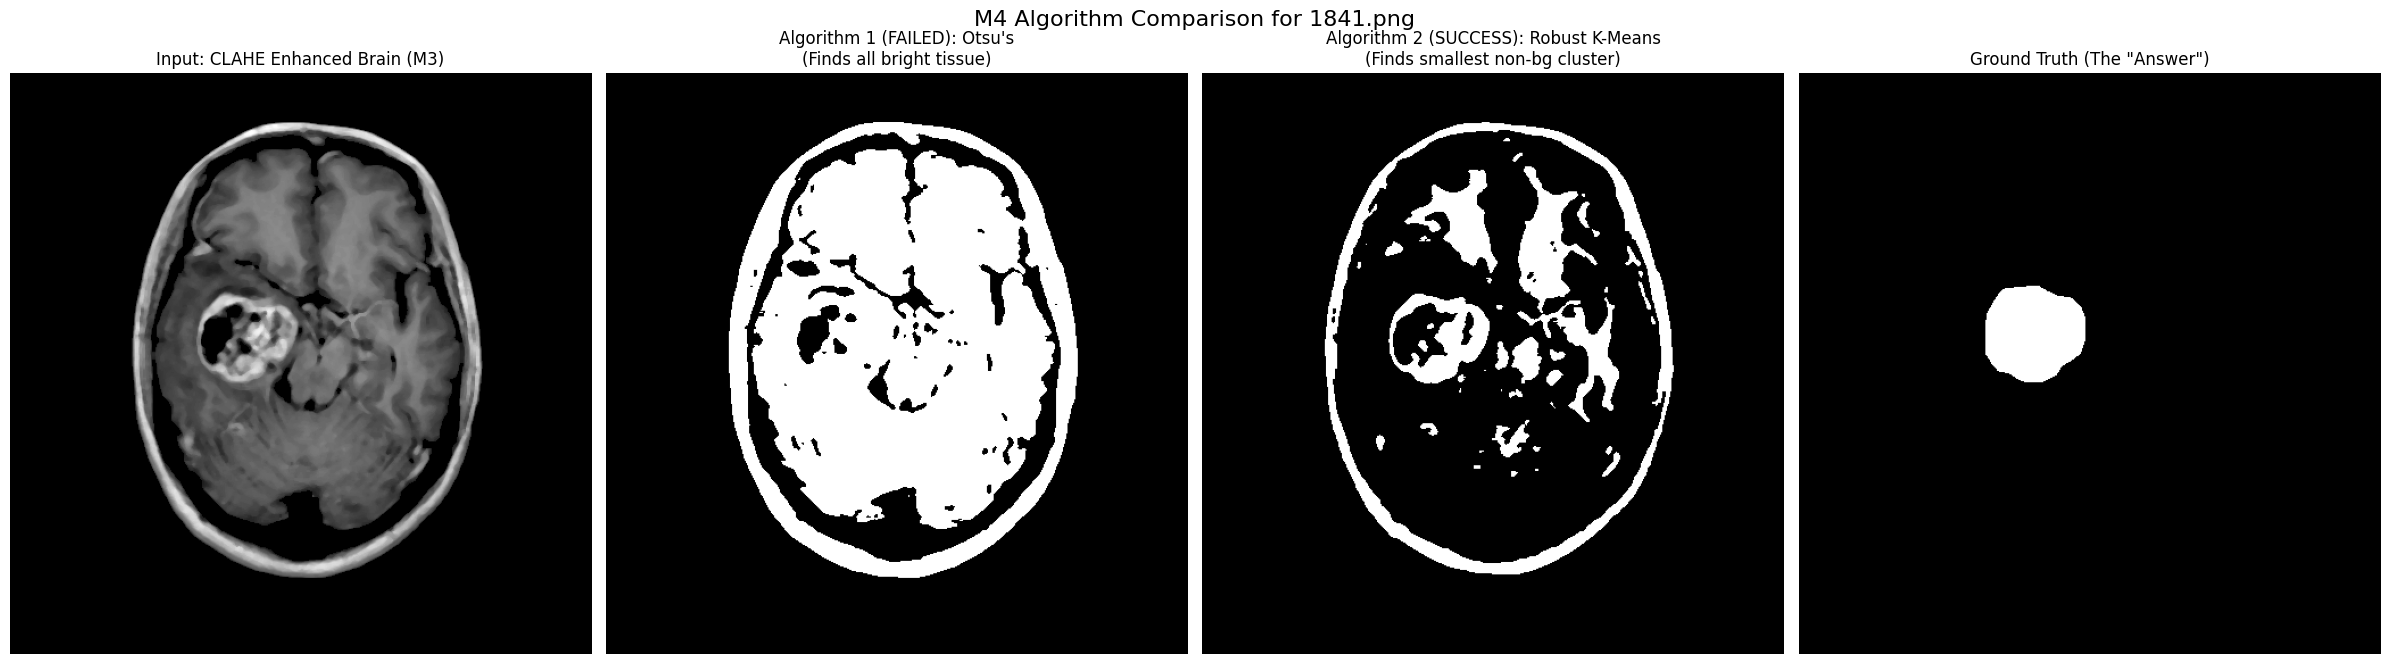


--- Comparative Analysis Finished ---


In [6]:
if clahe_img is None or gt_mask is None:
    print(f"ERROR: Cannot load example files. Check paths:")
    if clahe_img is None: print(f"  Missing: {clahe_img_path}")
    if gt_mask is None: print(f"  Missing: {gt_mask_path}")
else:
    # Run Otsu's (Failed)
    otsu_mask = segment_tumor_otsu(clahe_img)

    # Run K-Means (Success)
    kmeans_mask = segment_tumor_kmeans_robust(clahe_img, K_CLUSTERS)

    # --- Plot the comparison ---
    fig, axes = plt.subplots(1, 4, figsize=(24, 7))
    fig.suptitle(f'M4 Algorithm Comparison for {EXAMPLE_FILE}', fontsize=16)

    axes[0].imshow(clahe_img, cmap='gray')
    axes[0].set_title('Input: CLAHE Enhanced Brain (M3)')
    axes[0].axis('off')

    axes[1].imshow(otsu_mask, cmap='gray')
    axes[1].set_title('Algorithm 1 (FAILED): Otsu\'s\n(Finds all bright tissue)')
    axes[1].axis('off')

    axes[2].imshow(kmeans_mask, cmap='gray')
    axes[2].set_title('Algorithm 2 (SUCCESS): Robust K-Means\n(Finds smallest non-bg cluster)')
    axes[2].axis('off')

    axes[3].imshow(gt_mask, cmap='gray')
    axes[3].set_title('Ground Truth (The "Answer")')
    axes[3].axis('off')

    plt.tight_layout()
    plt.show()

print("\n--- Comparative Analysis Finished ---")

In [7]:
print(f"--- Starting Module 4: Robust K-Means Segmentation (Batch Process) ---")
start_time = time.time()

for tumor_type in TUMOR_TYPES:
    clahe_dir = os.path.join(CLAHE_BASE_DIR, tumor_type)
    output_dir = os.path.join(PRED_MASK_BASE_DIR, tumor_type)
    os.makedirs(output_dir, exist_ok=True) # Ensure output dir exists

    search_pattern = os.path.join(clahe_dir, '*_clahe.png')
    clahe_paths = glob.glob(search_pattern)

    print(f"\nProcessing {len(clahe_paths)} images in {tumor_type}...")

    for i, clahe_path in enumerate(clahe_paths):
        try:
            img = cv2.imread(clahe_path, 0)
            if img is None:
                print(f"Warning: Could not read {clahe_path}. Skipping.")
                continue

            # Run the new robust K-Means segmentation
            tumor_mask = segment_tumor_kmeans_robust(img, K_CLUSTERS)

            # Save the resulting tumor mask
            base_filename = os.path.basename(clahe_path)
            output_filename = base_filename.replace('_clahe.png', '_tumor_mask.png')
            output_path = os.path.join(output_dir, output_filename)
            cv2.imwrite(output_path, tumor_mask)

            # Print progress
            if (i + 1) % 200 == 0:
                print(f"  ...processed {i+1} images")

        except Exception as e:
            print(f"ERROR processing {clahe_path}: {e}")

    print(f"  ...Finished processing {len(clahe_paths)} images.")

end_time = time.time()
print(f"\n✅ Module 4 (K-Means Segmentation) complete.")
print(f"All predicted masks are saved in: {PRED_MASK_BASE_DIR}")
print(f"Total processing time: {end_time - start_time:.2f} seconds")

--- Starting Module 4: Robust K-Means Segmentation (Batch Process) ---

Processing 708 images in Meningioma...
  ...processed 200 images
  ...processed 400 images
  ...processed 600 images
  ...Finished processing 708 images.

Processing 1426 images in Glioma...
  ...processed 200 images
  ...processed 400 images
  ...processed 600 images
  ...processed 800 images
  ...processed 1000 images
  ...processed 1200 images
  ...processed 1400 images
  ...Finished processing 1426 images.

Processing 930 images in Pituitary tumor...
  ...processed 200 images
  ...processed 400 images
  ...processed 600 images
  ...processed 800 images
  ...Finished processing 930 images.

✅ Module 4 (K-Means Segmentation) complete.
All predicted masks are saved in: /content/drive/MyDrive/kmeans_tumor_masks
Total processing time: 1842.65 seconds


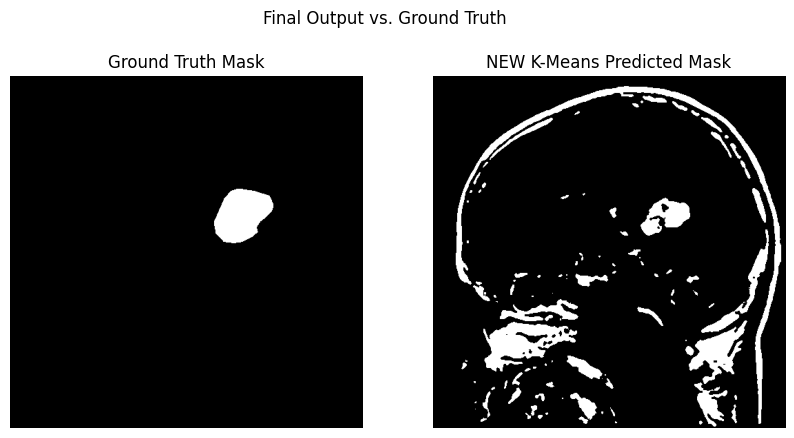

Verification complete. Compare the two images.


In [9]:
TUMOR_TYPE_EXAMPLE = 'Meningioma'
EXAMPLE_FILE = '708.png' # Use the one that was a good result

# Paths
gt_mask_path = os.path.join(DATA_BASE_DIR, TUMOR_TYPE_EXAMPLE, EXAMPLE_FILE.replace('.png', '_mask.png'))
pred_mask_path = os.path.join(PRED_MASK_BASE_DIR, TUMOR_TYPE_EXAMPLE, EXAMPLE_FILE.replace('.png', '_tumor_mask.png'))

# Load
gt_mask = cv2.imread(gt_mask_path, 0)
pred_mask = cv2.imread(pred_mask_path, 0)

if gt_mask is None or pred_mask is None:
    print("ERROR: Could not load verification images. Check paths.")
else:
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(gt_mask, cmap='gray')
    axes[0].set_title('Ground Truth Mask')
    axes[0].axis('off')

    axes[1].imshow(pred_mask, cmap='gray')
    axes[1].set_title('NEW K-Means Predicted Mask')
    axes[1].axis('off')

    plt.suptitle("Final Output vs. Ground Truth")
    plt.show()

    print("Verification complete. Compare the two images.")

In [10]:
import shutil

source_dir = '/content/drive/MyDrive/kmeans_tumor_masks'
output_filename = '/content/drive/MyDrive/kmeans_tumor_masks.zip'

# Create a zip file of the directory
shutil.make_archive(output_filename.replace('.zip', ''), 'zip', source_dir)

print(f"Directory '{source_dir}' has been successfully zipped to '{output_filename}'. You can now download this file from Google Drive.")

Directory '/content/drive/MyDrive/kmeans_tumor_masks' has been successfully zipped to '/content/drive/MyDrive/kmeans_tumor_masks.zip'. You can now download this file from Google Drive.
